# Using Time Series Analysis to Forecast U.S Monthly Births

### By [Ruben Olmos](rubenolmos.com)

# Abstract

The intended purpose of this project is to provide an analysis and forecast of monthly births in the U.S. The data that is used for this attempt was sourced from r package astsa. The data provides us with historical U.S monthly live birth data from January of 1948 to January 1949 taking into consideration all the births across the U.S. We hope to come up with a viable model and henceforth forecast the number of monthly births for the United States.Through an analysis of the data we are able to see that the data is able to be viably modeled with an Sarima model and then after forecasted. Through the fitted Sarima model we are able to make a mathematically sound prediction of monthly births for the United States.

# Introduction
The data set granted by the astsa package in r provides 373 observations recording monthly live births in the U.S from January 1948 to January 1979.
The interest in an analysis and forecasting of this type came of interest out of an abnormally cultural discussion of recent years on overpopulation. A wide variety of scientific and social fields take interest in the metrics of population including of course the prediction of the amount of births that shall occurr in the future. Out of this highly discussed matter stemmed my interst in this analysis. My immediate thought was that the number of births would, in more modern times, be much larger than in the past. However upon looking at the data it is immediately impressible that the number of births in more modern times is drastically lower than in the past. We are also able to see rises and falls of these numbers. Althought the analysis of why these things happend is beyond the scope of this project, some surface thought on the matter is useful in providing behavioral explanations discovered in this analysis. After analysis we are able to see that we can successfully fit a seasonal Arima model and successfully forecast future birth numbers with great confidence. In procedure:I removed the last 12 observations from the original data set in order to test the success of my forecasting. To achieve stationarity, I used techniques involving differencing at lag 12 and lag 1 to remove seasonality and trend but did not use Box-Cox transformations because of its triviality in this application. Then I used ACF/PAC to preliminary identify suitable SARIMA models, compared their AIC, and used standard errors of the ML estimates of model parameters to improve the model. Then I performed diagnostic checking to
test whether the selected time series model is a good representation of the data. Finally, I used the
final model to forecast and compare it with 12 observations I initially removed to test against it.
Throughout this project, I used RStudio and R programming language. 
suggested by my final model.

# Loading the Necessary packages


In [6]:
library(tidyverse)
library(tseries)
library(readxl)
library(MASS)
library(data.table)
library(forecast)
library(astsa)
library(alr3)
library(tseries)
library(ggplot2)
library(AICcmodavg)
library(sarima)
library(TSA)
library(forecast)
library(sarima)


## Plot and Analysis of Data for Monthly U.S Births from 1948 to 1979

In [4]:
births<-as.data.frame(birth)
actual<-as.data.frame(births[362:373,])
birtht<-as.data.frame(births[1:361,])
birt<-birtht %>%
  rename(births='births[1:361, ]')
birth<-births %>% 
  rename(births = x)
birthts<-ts(birt,start=c(1948,1),end=c(1978,1),frequency = 12)
birthss<-ts(births,start=c(1948,1),end=c(1979,1),frequency = 12)

## Initial Time Series Plot of U.S births data

We begin by plotting the data for monthly births in the U.S from 1948 to 1978, where we have removed the last 12 values that will be used in testing our forecasting model once fitted. Above we can see that the data is not stationary. We observe an upward trend from the beginning of 1950 to the beginning of 1960 and from that point forward an overall downaward trend. These trends can be associated with post-war birth explosions and later cultural shifts from the 1960's forward that decreased the amount of children being conceived.We can also see hints of seasonality with peaks at equally spaced time points falling roughly at the end of the year. This can be ascribed to the count of live births being additive to previous births earlier in the year and reaching larger values towards the end of each year.
These assumptions of course must be verified with analysis of the data.

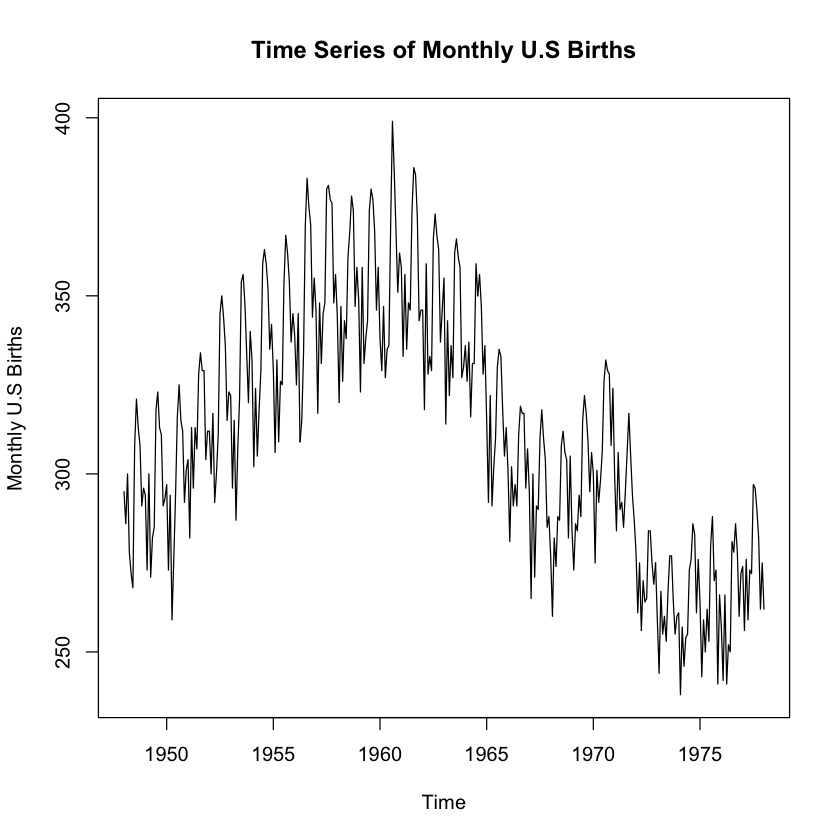

In [5]:
plot.ts(birthts,main="Time Series of Monthly U.S Births",ylab="Monthly U.S Births")

## Decomposing U.S Monthly births into seasonal and trend components

We decompose the data set into its additive components using the stl() function in order to further gain some confirmation or corrections of our immediate assumptions. 
We look at the trend component and the seasonal component of the decomposotion function and see that there is in fact trend and seasonality present in the data.

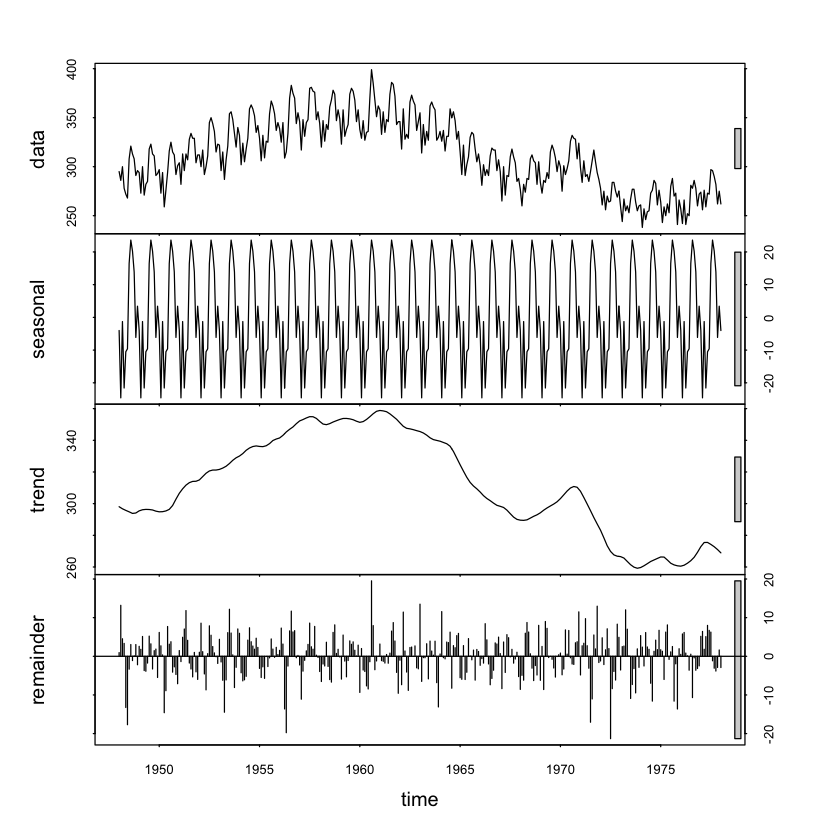

In [7]:
par(mfrow=c(1,1))
decomp<-stl(birthts[,1],s.window="periodic")
plot(decomp)

## Auto Correlation Function and Partial Auto Correlation Function of U.S Monthly Births Data

Further we look at the ACF of the data and see that seasonality also becomes apparent here.We will then have to account for seasonality and trend when fitting our model. Howeve prior to fitting the model an assumption of normality must be satisifed in order to properly fit time series models that assume normality.We plot a histogram of the data to observe whether normality is present.

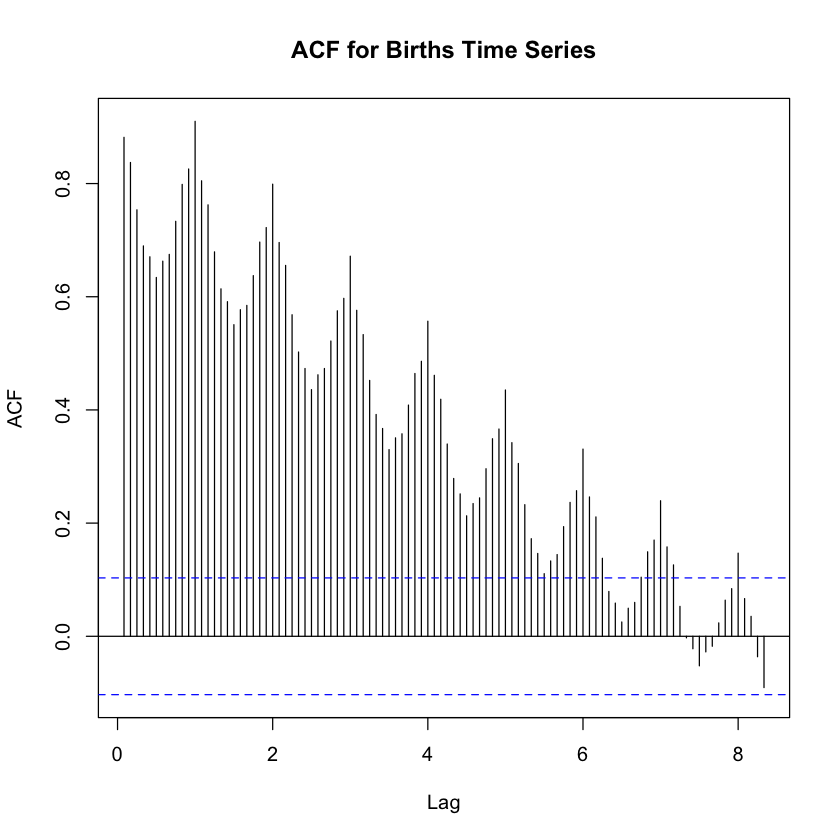

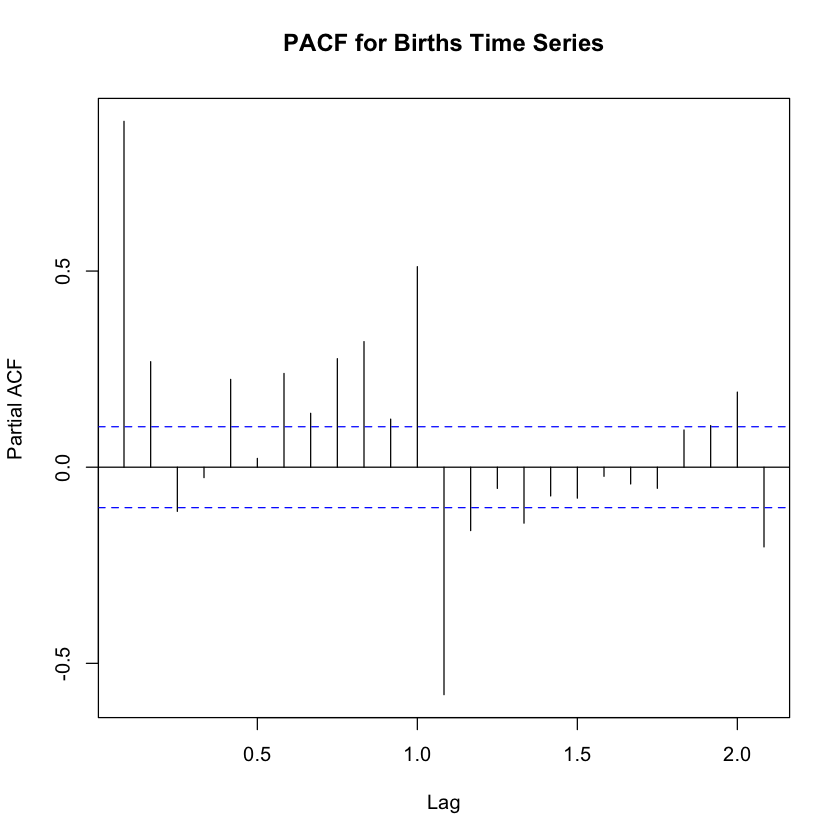

In [54]:
acf(birthts,main="ACF for Births Time Series",lag.max=100)
pacf(birthts,main="PACF for Births Time Series")

## Checking for the assumption of normality 

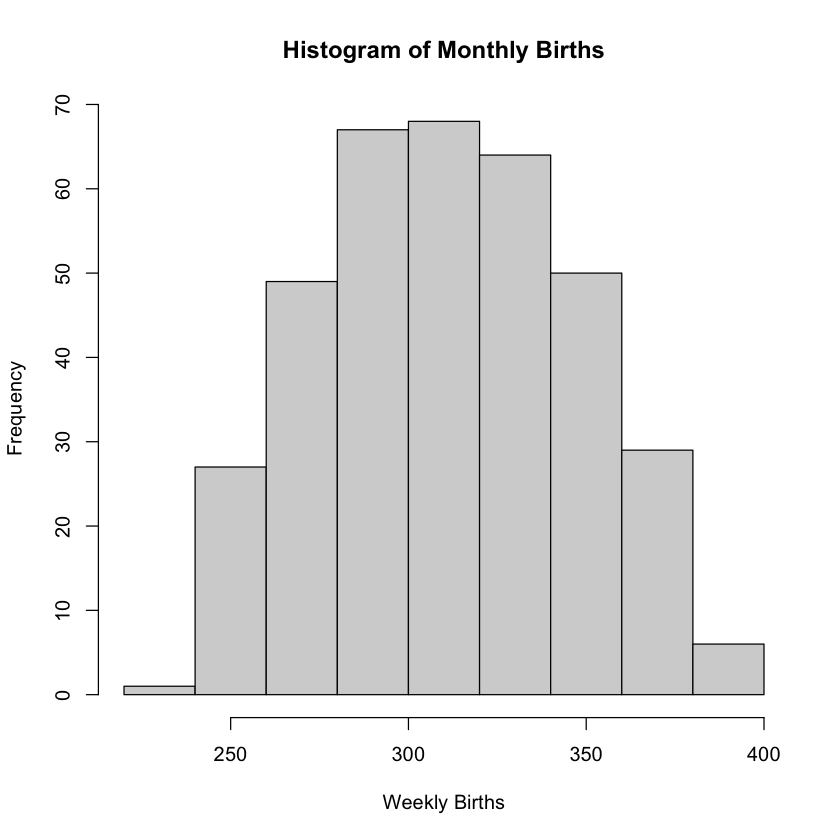

In [9]:
hist(birthts,main="Histogram of Monthly Births",xlab="Weekly Births")

We see that the data is already normalized and it might seem unecessary to apply a box cox transformation to our data. A Box-Cox transformation is applied with the purpose of normalizing data, our data is normalized already however it might be possible for our data to improve by applying the transformation.For the purposes of checking we go through with the transformation and observe what happens.

## Applying Box Cox Transformation to Check for Improvement 

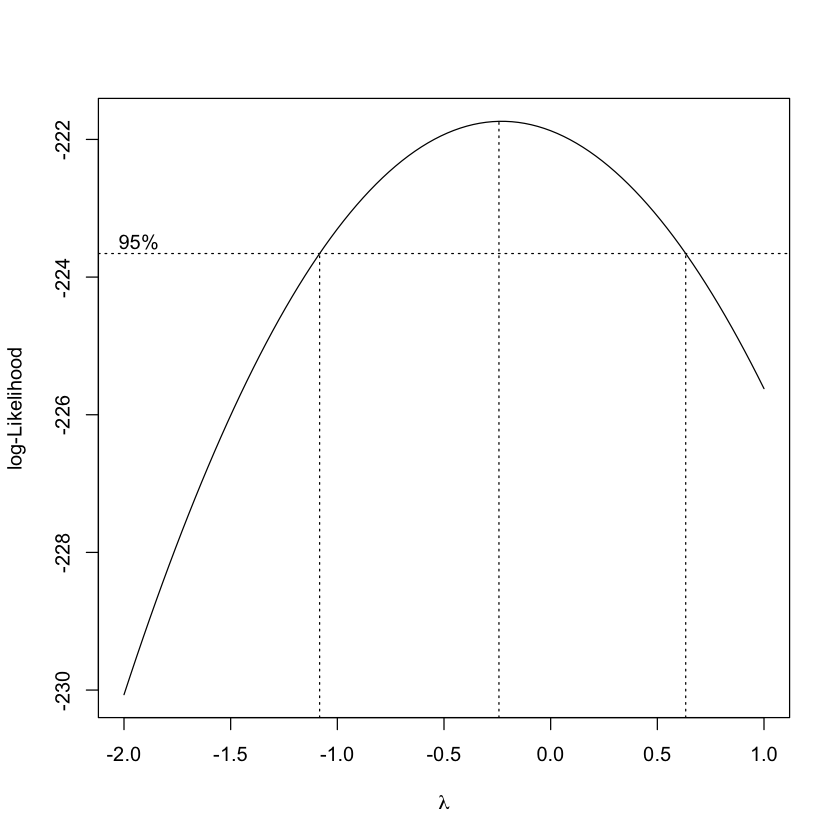

In [49]:
t = 1:length(birthts)
bcTransform<-boxcox(birthts ~ t,lambda = seq(-2,1,1/10),plotit = TRUE)
lambda=bcTransform$x[which(bcTransform$y==max(bcTransform$y))]
birth.bc<-(1/lambda)*((birthts^lambda)-1)

actual<-as.data.frame(births[362:373,])
actual.bc<-(1/lambda)*((actual^lambda)-1)

Looking at the plot of the box cox we see that the possible values of lambda around the value of -1, our lambda for purposes of convenience is chosen to be -0.3939393939. The transformation takes the form of Ti=((yi^(lambda))-1)/(lambda) where yi is our original data, lamda=-0.3939393939 and Ti is our transformed data.

## Comparing Histograms: Transformed v.s Untransformed data

We plot the histogram and time series of the transformed data and compare to old ones to seee how our data was transformed. 

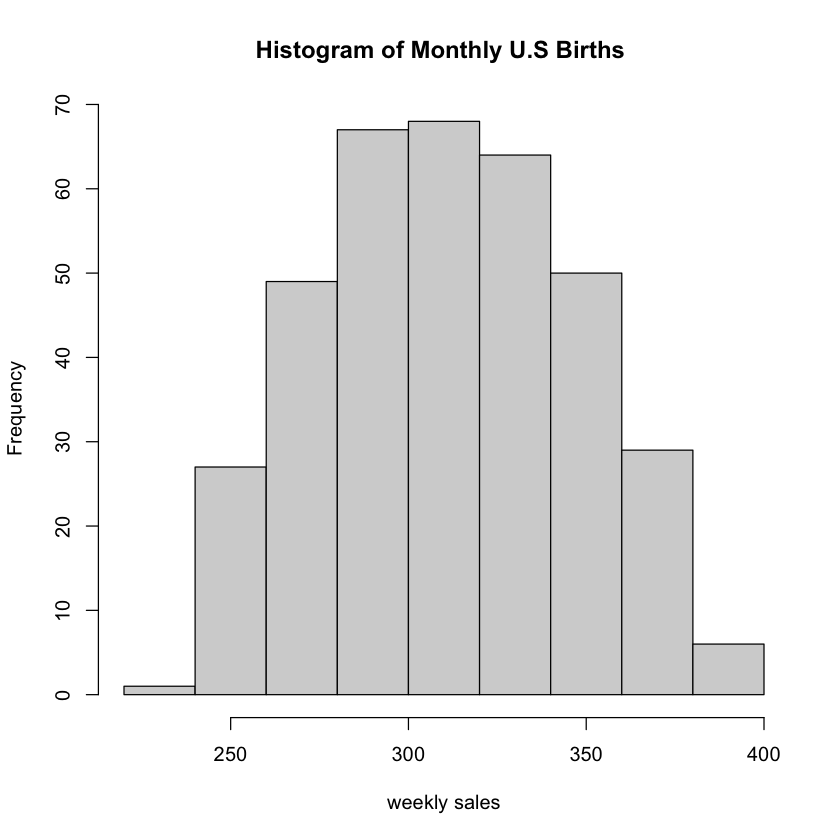

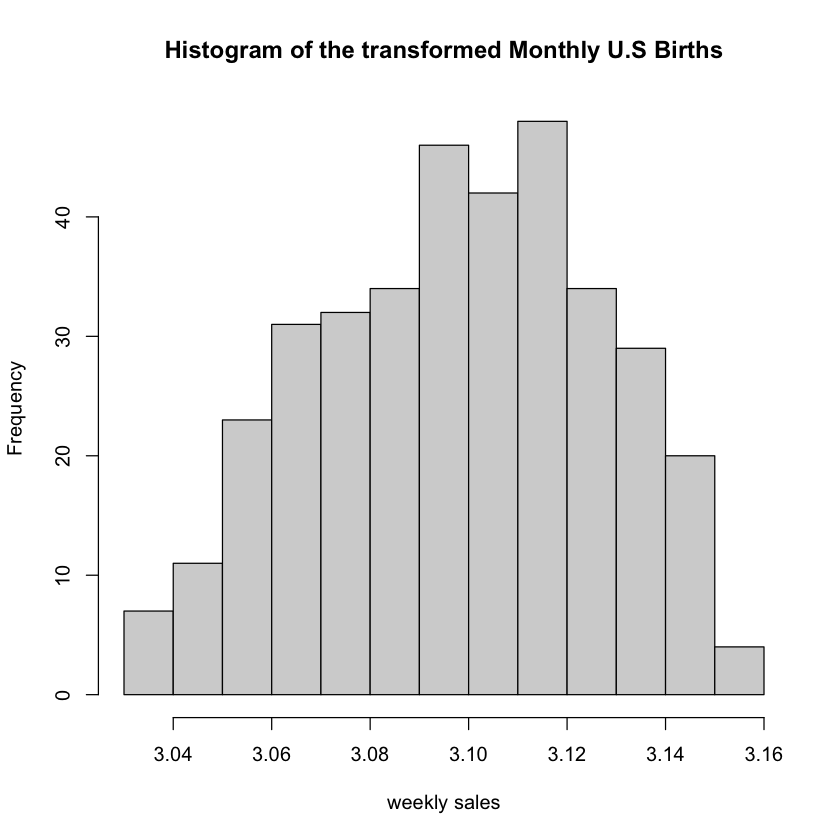

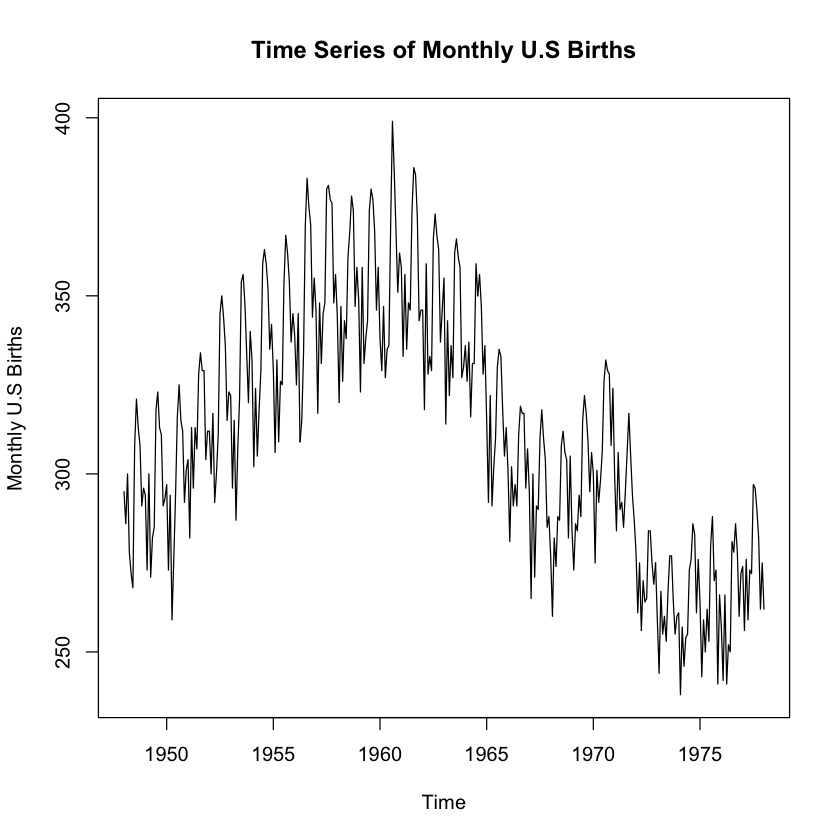

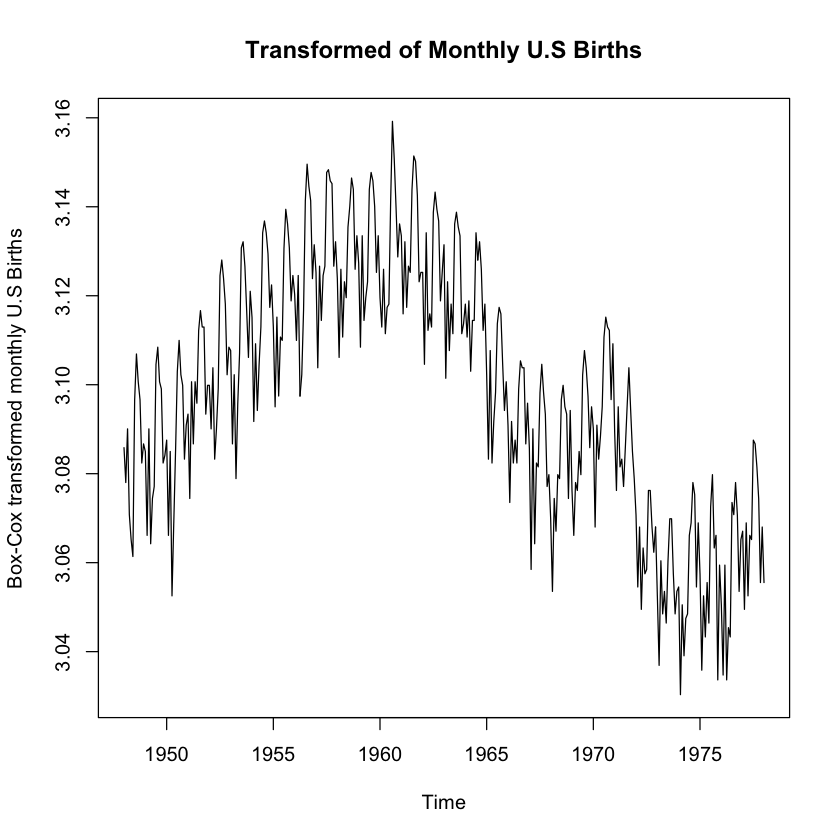

In [55]:

hist(birthts,main="Histogram of Monthly U.S Births ", xlab="weekly sales")
hist(birth.bc,main="Histogram of the transformed Monthly U.S Births",xlab="weekly sales")
plot.ts(birthts,main="Time Series of Monthly U.S Births",ylab="Monthly U.S Births")
plot.ts(birth.bc, main="Transformed of Monthly U.S Births", ylab="Box-Cox transformed monthly U.S Births")

Above we can compare the differences in the data after the Box-Cox transformation with paramter of (-0.8282828). We see that our transformed data holds a normalized shape, the transformation was then successful in satisfying normality. The prequiste of normality is confirmed to be satisfied and we begin to fit the data into model that draw on an assumption of normality. We first compare the variances of our box-cox transformed data and our original data.

## Comparison of Variances: Transformed v.s Untransformed

In [20]:
var(birthts)
var(birth.bc)

,births
births,1240.041


,births
births,0.0008032222


We see that the variance does in fact decrease in this case. Judging from this result it is a good idea to accept the box cox transformation. A smaller variance wil allow our models to fit much better and provide a more accurate representation of our data.Further we accept the box-cox transformation and proceed to extract any present seasonality and present trend in order to properly model the data. We decompose the newly transformed data using the stl() function to observe the additive components of the data and gain insight into how we should further model the data. We also plot the acf and pacf of the transformed data to gain further insight into how we should remove trend and seasonality.


## Decomposing Transformed Data: Auto Correlation and Partial Auto Correlation Functions


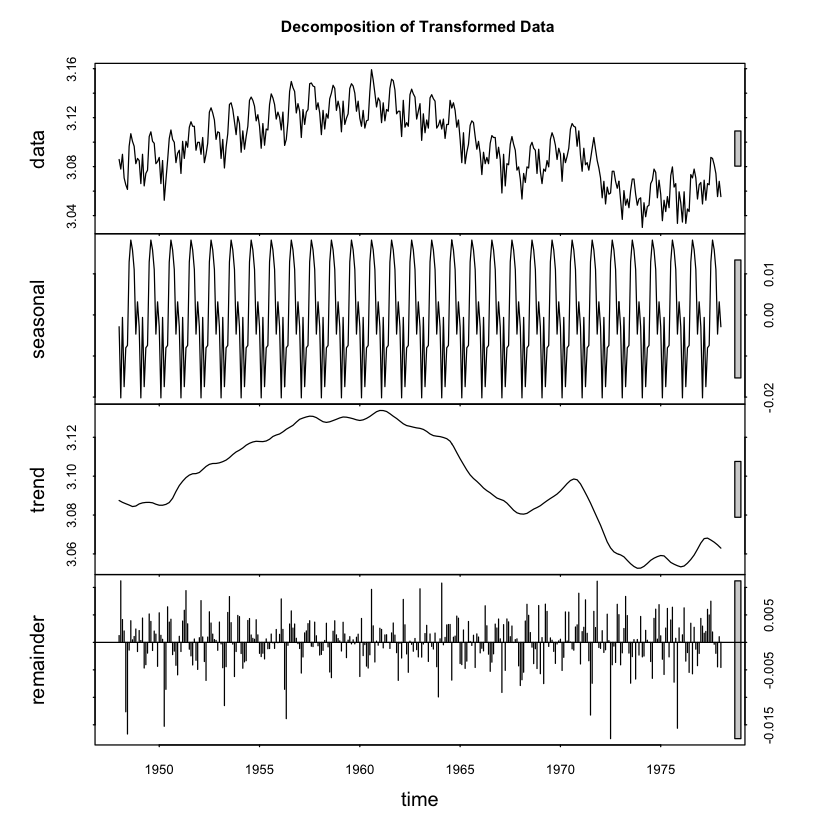

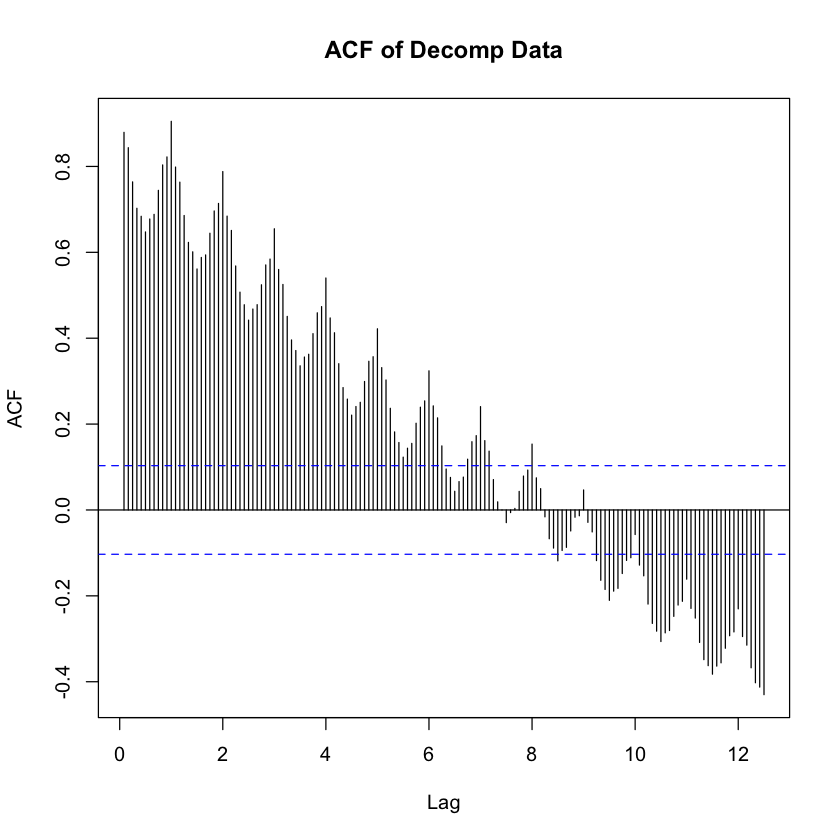

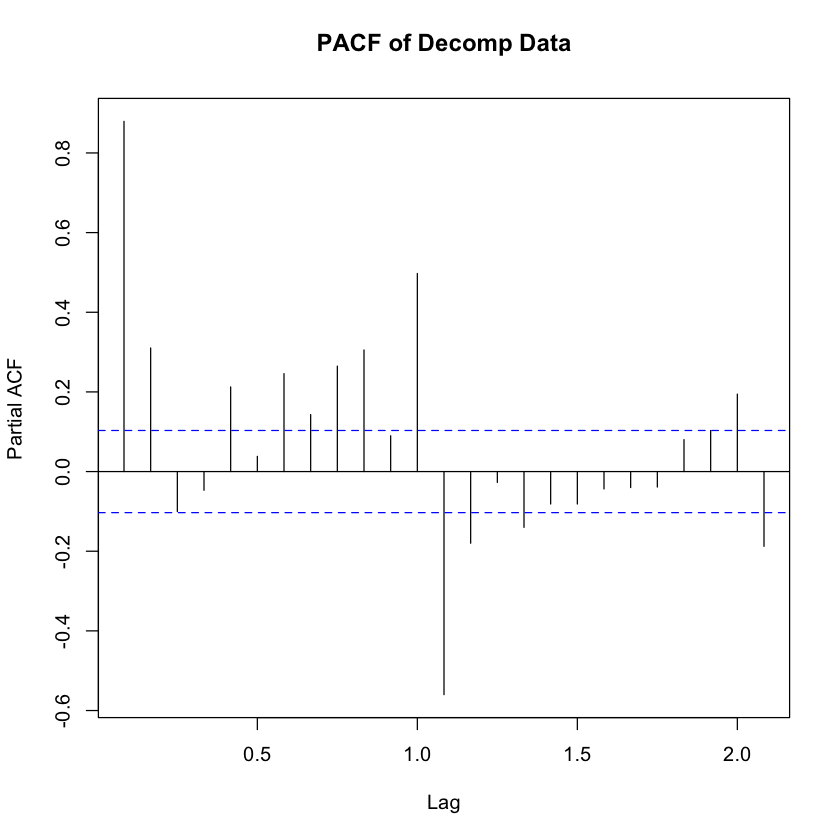

In [56]:

decomp1<-stl(birth.bc[,1],s.window="periodic")
plot(decomp1,main="Decomposition of Transformed Data ")
acf(birth.bc,main="ACF of Decomp Data",lag.max=150)
pacf(birth.bc,main="PACF of Decomp Data")

We plot the decomposition of the transformed data,the ACF and PACF after having confirmed that the Box-Cox transformation was warranted.The decomposition of the data shows that there is a upward trend this suggest that we must remove trend from the data.In the decompostion we also see that there is a high amount of seasonality at about the end of each year. This is also observed in the ACF of the data. The ACF takes on a shape that suggests that there is seasonality in our data. The Acf seems to suggest that we have seasonality at lag=12 as we suspected from the plot of our time series at the beginning of our analysis. We begin by differencing at lag=12 and then address the trend in our data by further differencing. 

## Differencing Data for Seasonality and Trend

In [23]:
deseas<-diff(birth.bc,12)
var(birth.bc)
var(deseas)

,births
births,0.0008032222


,births
births,0.0001085371


We see that the variance decreases when we difference at lag=12. This implies that we should infact difference at the seasonal lag of 12.

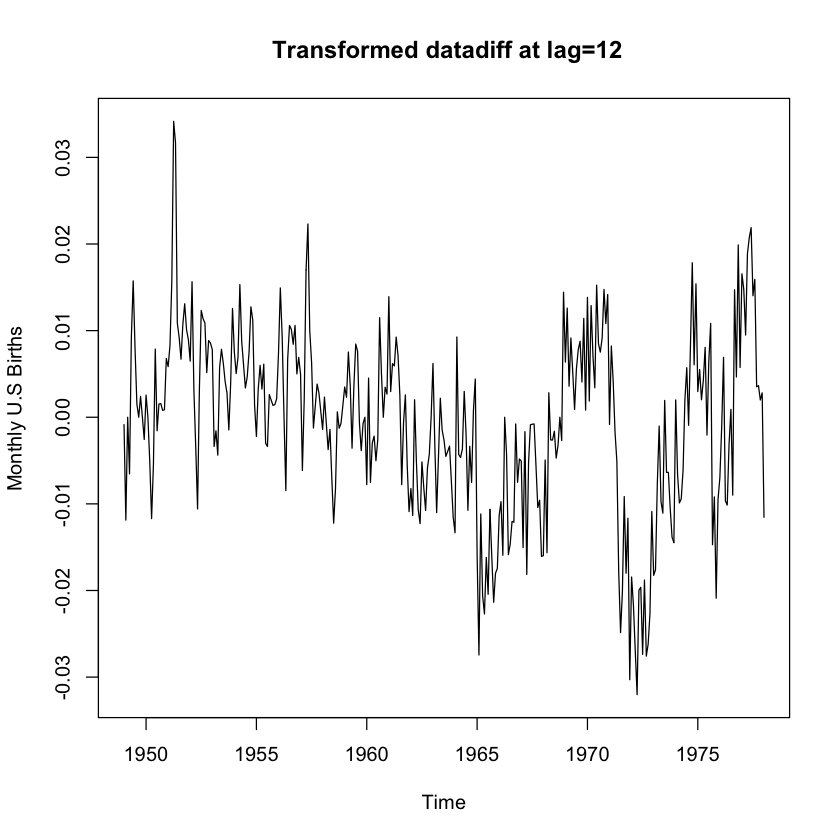

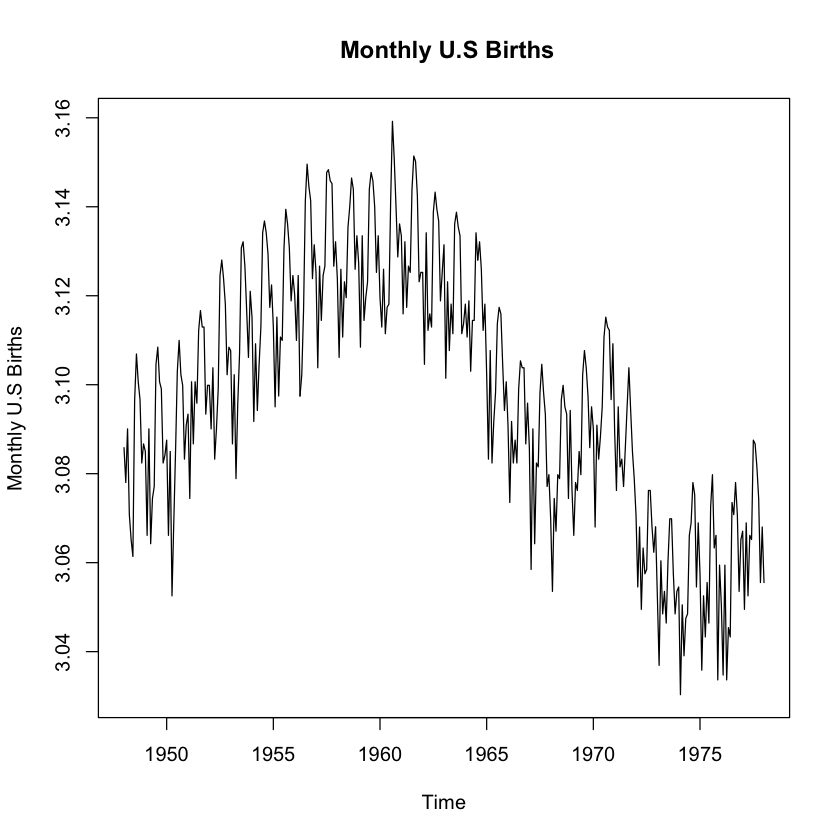

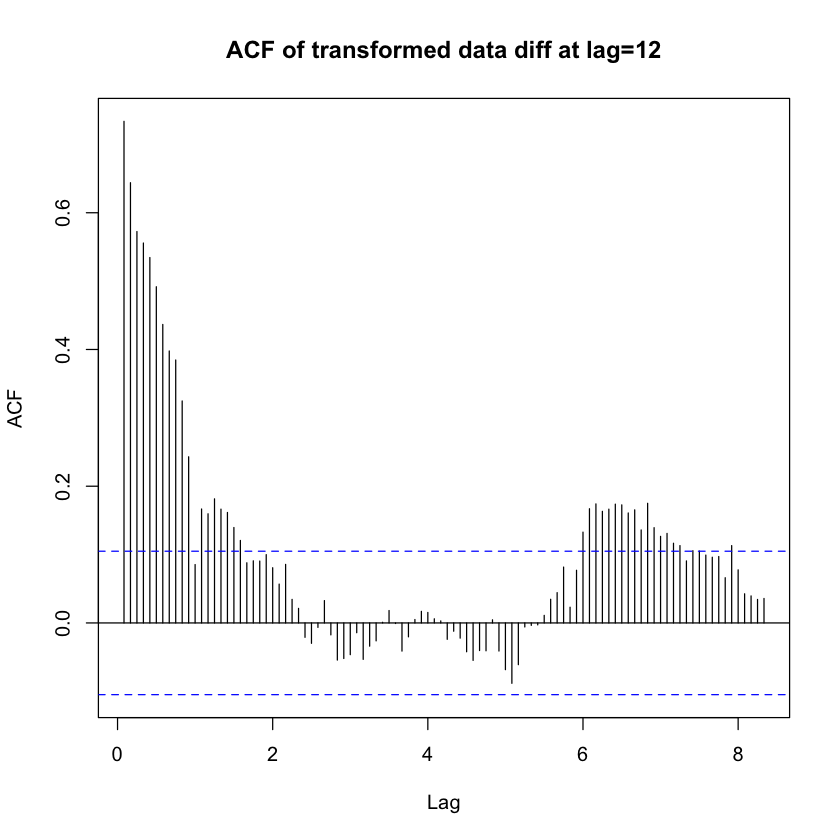

In [51]:
plot.ts(deseas,main=" Transformed datadiff at lag=12",ylab="Monthly U.S Births")
plot.ts(birth.bc,main=" Monthly U.S Births",ylab="Monthly U.S Births")
acf(deseas,main="ACF of transformed data diff at lag=12",lag.max=100)

we see that the time series of the differenced data at lag=12 shows no seasonality . This is further confirmed in the plot of the acf after differencing at lag=12, where seasonality is no longer apparent.Now we investigate how much differencing must be done to adress trend in our data by comparing variances after differencing further.

## Further Differencing to Remove Trend

In [25]:
d1<-diff(deseas,1)
var(deseas) #variance of data differenced at lag=12
var(d1) #variance of data differenced at lag=12 and lag=1

,births
births,0.0001085371


,births
births,5.762404e-05


We see that differencing further at lag=1 our variance decreases, with the top variance being our data differenced at lag=12 and the bottom variance being our data differenced at lag=12 and lag=1. Perhaps it is necessary to difference further so we further attempt to difference and observe the affect on the variance.

### Diferrencing Further to check if model can be improved further

In [ ]:
d2<-diff(d1,1)
var(d1) #variance of data differenced at lag=12 and lag=1
var(d2) #variacne of data differenced at lag=12 and lag=1 and further differenced at lag=1

Letting the top variance be that of our box-cox transformed data differenced at lag=12 and lag=1 and the bottom variance the one further differencing at a lag=1, we see that if we further difference the variance increases if we continue to difference. This suggest that we should only difference our data at lag=12 and lag=1. This indicates that differencing for trend can be accounted by differencing at lag=1 and differencing for seasonality can be accounted by differencing at lag=12.

## Plotting Untransformed, Transformed and Differenced for Trend/Seasonality U.S Monthly Births Data 

### Untransformed Data 

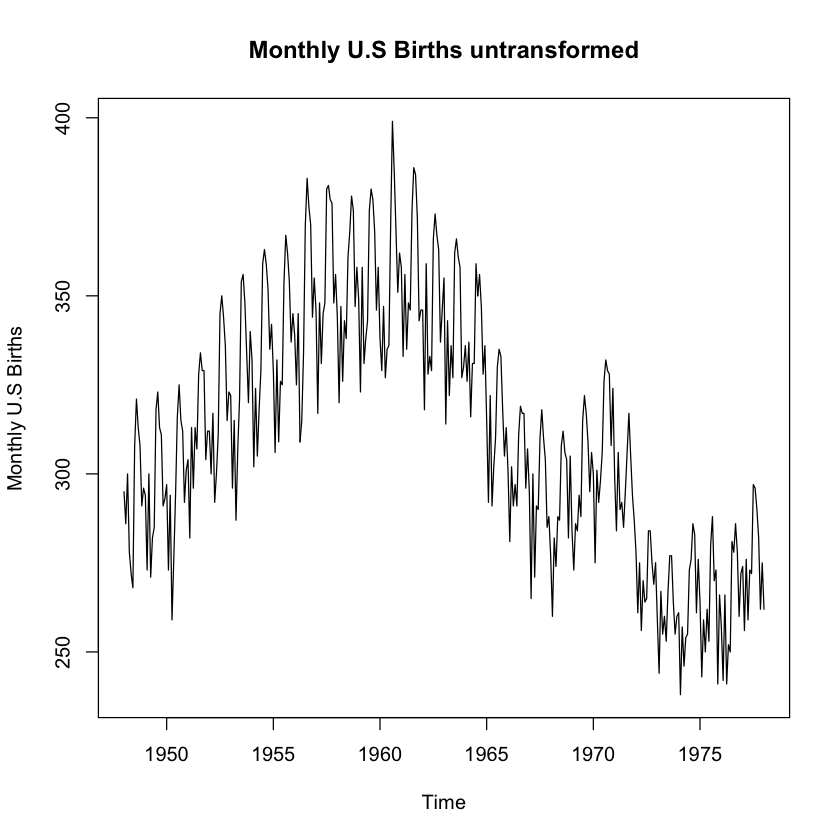

In [30]:
plot.ts(birthts,main="Monthly U.S Births untransformed",ylab="Monthly U.S Births")

### Box-Cox Transformed Data

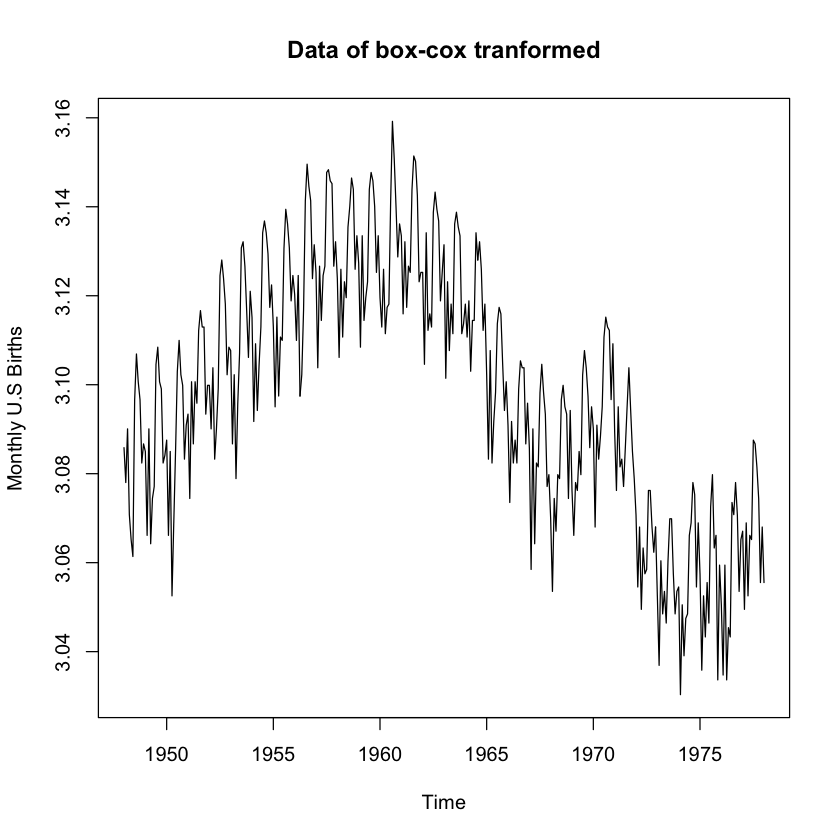

In [27]:
plot.ts(birth.bc,main="Data of box-cox tranformed", ylab="Monthly U.S Births")

### Detrended and Deseasoned Data

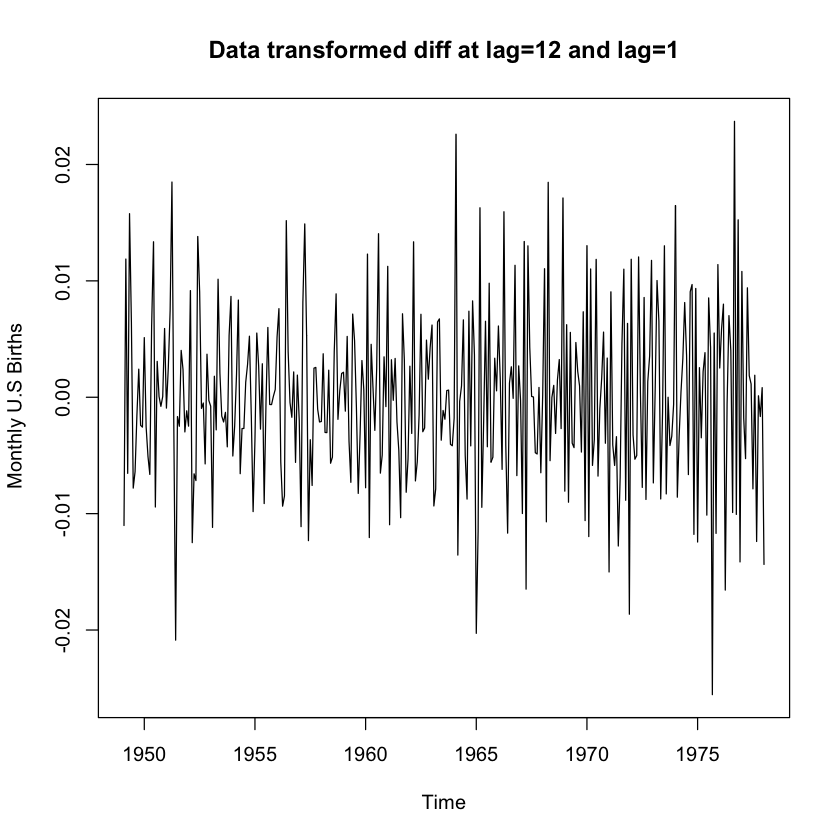

In [28]:
plot.ts(d1,main="Data transformed diff at lag=12 and lag=1",ylab=" Monthly U.S Births")

We see that the data has a more stationary shape with more less volatility and  no trend or seasonality. We run a test to see that we do in fact have a stationary series.

## Running a Augmented Dickey Fuller Test, Testing for Stationarity of Detrended and Deseasoned Data

In [50]:
adf.test(d1)

Warning message in adf.test(d1):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  d1
Dickey-Fuller = -8.1202, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


We see that our p-value is .01 and accept the hypothesis that we have a stationary distribution. Given that we have removed seasonality and trend and have a normally distributed time series we can proceed to fit models that draw on these assumptions.We begin by looking at the pacf and acf to hypothesize candidate models.

## Fitting a Model 

### Assessing ACF and PACF of Stationary Model

In [ ]:
acf(d1,main="ACF of data diff at lag=12 and lag=1")
pacf(d1,main="PACF of data diff at lag=12 and lag=1")

We see in the ACF that we have spikes after lag=12 this suggest one polynomial for the MA portion leading Q=1. Looking at the PACF we see that we have spikes only after lag=12 as well this suggests that P=1. Then our model will be an SARIMA with P=1,Q=1,d=1 and D=1. We see in the ACF that we have the lags 1,9,11,12,13,25 outside the confidence interval and in the PACF we see the lags 1,2,3,4,11,12,15,23,24,15 outside the lags but because of properties of seasonality we consider the cases of q=0,1,3 and maybe q=4,5 we neglect the larger lags reverting to the principle of parsimony. We consider the cases for p=1,2,3,4 and maybe p=5 and neglect the larger ones by the principle of parsimony. Judging with all these facts we see that the pacf and Acf seem to suggest a SARIMA(4,1,1)(1,1,1)[12] since the lag of the ACF seems to decay after lag 1 ignoring seasonal laga 12 and larger lag values such as lag 13,likewise,the PACF seems to decay more after lag 4 ignoring larger values such as 11 and seasonal lags such as 12. Therefore the guess for the model is SARIMA(4,1,1)(1,1,1)[12]. We now proceed to test our assumption by attempting to fit our model using aicc criterion comparisons of candidate models.

### Using AICC Criteria to Fit Model 

In [32]:
aicc<- function(model){
  n = model$nobs
  m = length(model$coef)
  aicc = model$aic + 2*m*(m+1)/(n-m-1)
  return(aicc)
}

In [33]:
arima(birth.bc,order=c(2,1,3),seasonal=list(order=c(1,1,1),period=12))
aicc(arima(birth.bc,order=c(2,1,3),seasonal=list(order=c(1,1,1),period=12)))
arima(birth.bc,order=c(3,1,3),seasonal=list(order=c(1,1,1),period=12))
aicc(arima(birth.bc,order=c(3,1,3),seasonal=list(order=c(1,1,1),period=12)))


Call:
arima(x = birth.bc, order = c(2, 1, 3), seasonal = list(order = c(1, 1, 1), 
    period = 12))

Coefficients:
         ar1      ar2      ma1     ma2      ma3    sar1     sma1
      0.7238  -0.9892  -1.1801  1.3151  -0.4793  0.0288  -0.8643
s.e.  0.0148   0.0173   0.0538  0.0450   0.0524  0.0698   0.0382

sigma^2 estimated as 2.838e-05:  log likelihood = 1319.18,  aic = -2624.36

[1] -2624.035


Call:
arima(x = birth.bc, order = c(3, 1, 3), seasonal = list(order = c(1, 1, 1), 
    period = 12))

Coefficients:
          ar1      ar2     ar3      ma1     ma2      ma3    sar1     sma1
      -0.3468  -0.7866  0.2859  -0.0517  0.5754  -0.6780  0.0589  -0.8743
s.e.   0.0910   0.0604  0.0898   0.0668  0.0433   0.0657  0.0667   0.0379

sigma^2 estimated as 2.845e-05:  log likelihood = 1317.88,  aic = -2619.76

[1] -2619.337

We run a comparison all possible models using the criterion listed above and implied by the PACF and ACF and arrive at the two best candidates shown above with their Aicc's.We see that the smallest aicc's are for the models: sarima(3,1,3)(1,1,1)[12] with an aicc of -2626.517 and sarima(2,1,3)(1,1,1)[12] with an aicc of -2627.7 we select these two models to run diagnostic tests on. We let the first model sarima(2,1,1)(1,1,1) be called fit1 and the second model sarima(3,1,3)(1,1,1)[12] be called fit2 and begin to run diagnostics.

## Diagnostic Testing Candidate models

In [34]:
fit1<-arima(birth.bc,order=c(2,1,3),seasonal=list(order=c(1,1,1),period=12))
fit2<-arima(birth.bc,order=c(3,1,3),seasonal=list(order=c(1,1,1),period=12))

## Diagnostic Testing Candidate Model 1

We begin by running diagnostics on fit 1, that is sarima(2,1,3)(1,1,1)[12]. We begin by looking at the variance and mean of the residuals. 

In [35]:
res1=residuals(fit1)
mean(res1)

var(res1)

[1] -0.0001579309

[1] 2.775195e-05

We see that the mean is close to zero and the variance is small. This is favorable and desirable in a model since we want to approximate a white noise process.

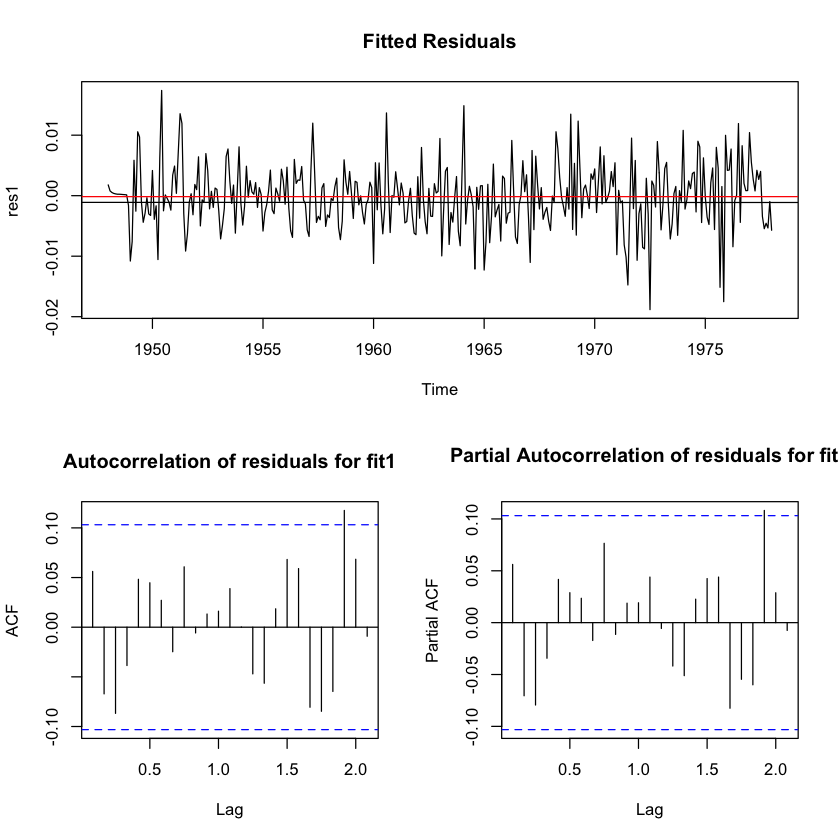

In [36]:
layout(matrix(c(1,1,2,3),2,2,byrow=T))
ts.plot(res1,main = "Fitted Residuals")
t = 1:length(res1)
fit.res1 = lm(res1~t)
abline(fit.res1)
abline(h = mean(res1), col = "red")
# acf
acf(res1,main = "Autocorrelation of residuals for fit1")
# pacf
pacf(res1,main = "Partial Autocorrelation of residuals for fit1")

Upon first imppression we see that we have some lags that are outside of the confidence interval, this is not necessarily favorable when wanted to fit a model. We cannot consider the pacfs and acfs as zero completely. It is in the interest that our pacf and acf fall within the confidence interval.

### Box Pierce test and Ljung-Box test

In [ ]:
Box.test(res1, lag = 12, type = c("Box-Pierce"), fitdf = 4)
Box.test(res1, lag = 12, type = c("Ljung-Box"), fitdf = 4)
Box.test(res1^2, lag = 12, type = c("Ljung-Box"), fitdf = 0)

The Box-Pierce test examines whether the residuals of the time series follow a white noise distribution. The Ljung-Box examines whether any group of autocorellations of a time series are nonzero. We see that for all test we have pvalues greater than 0.05. Our first fitted model passes all three of these tests. Further we proceed to run a McLeod.Li.test and shapiro test.

### McLeod-Li and Shapiro Test 


	Shapiro-Wilk normality test

data:  res1
W = 0.98964, p-value = 0.01176


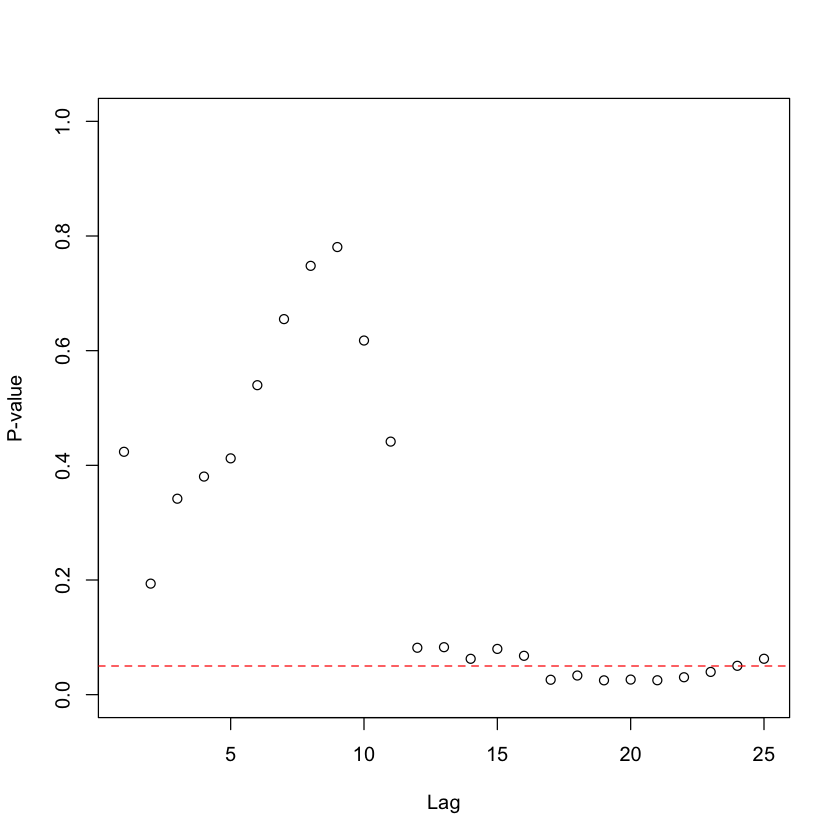

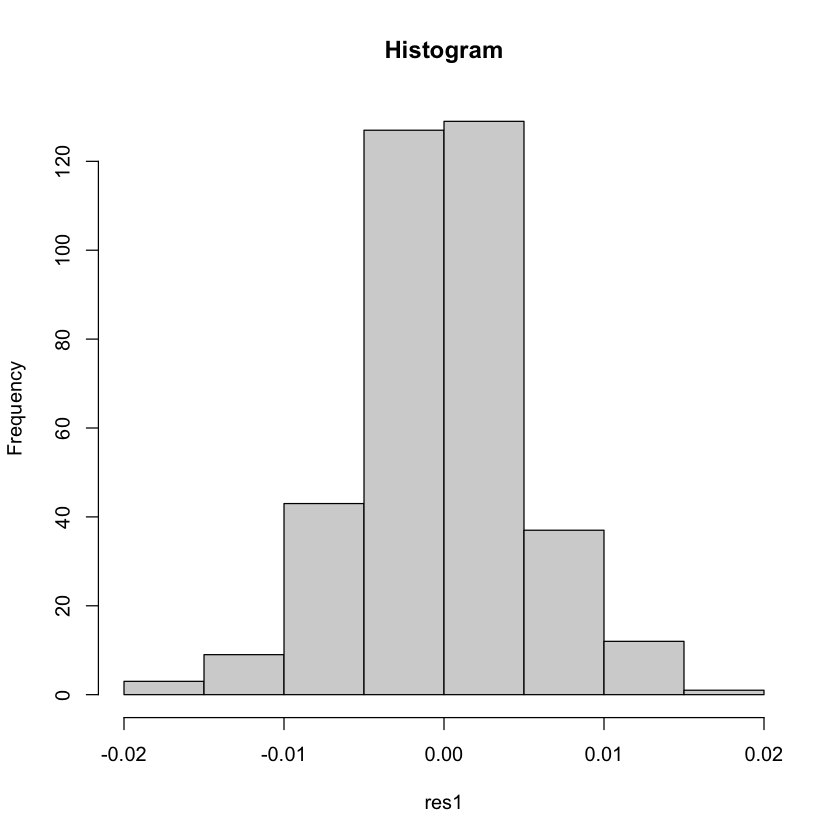

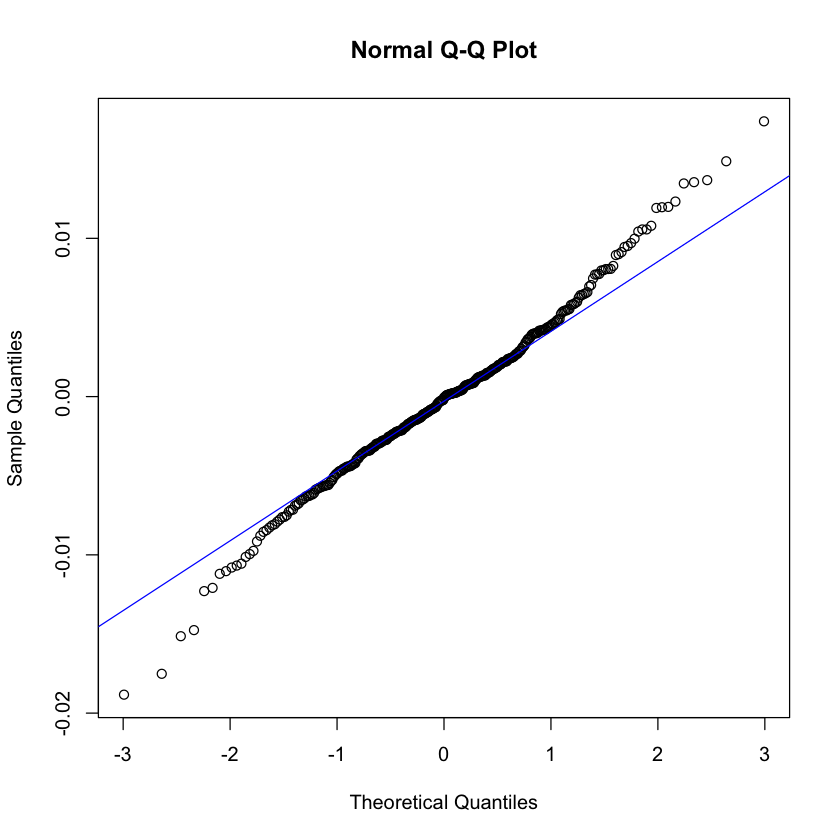

In [52]:
McLeod.Li.test(fit1)
shapiro.test(res1)
# Histogram
hist(res1,main = "Histogram")
# q-q plot
qqnorm(res1)
qqline(res1,col ="blue")

The shapiro test is a test of normality for the residuals. We see that our fitted model passses fails this test with the p-value being less than 0.05 despite the histogram taking on a normal shape and Q-Q plot holding the majority of the points on the line. The null hypothesis of the McLeod and Li test is that there is no autoregressive conditional heteroskedasticity (ARCH) among the lags considered. In the case of the McLeod.Li.test we see that greater than 5% of our points fall below the red line, this indicates that we fail the test and reject the null there is no autoregressive conditional heteroskedasticity. We proceed to look at the second candidate model and start by looking at the mean and variance of the residuals.

## Diagnostic Testing Candidate Model 2

In [38]:
res2 = residuals(fit2)
mean(res2)
var(res2)

[1] -0.0002045026

[1] 2.779901e-05

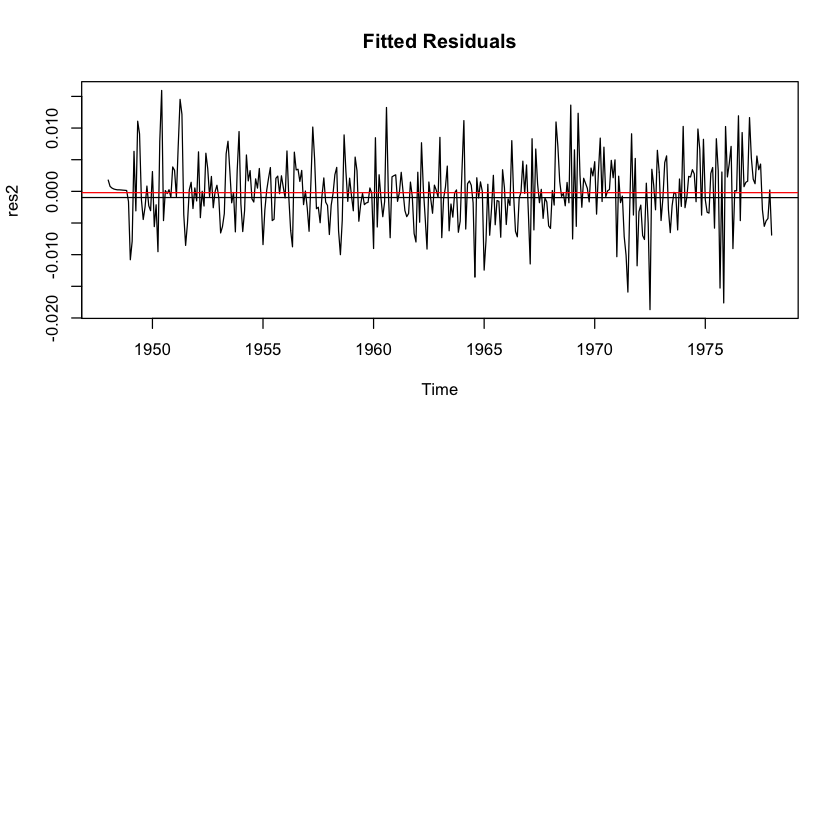

In [39]:
layout(matrix(c(1,1,2,3),2,2,byrow=T))
ts.plot(res2,main = "Fitted Residuals")
t = 1:length(res2)
fit.res2 = lm(res2~t)
abline(fit.res2)
abline(h = mean(res2), col = "red")

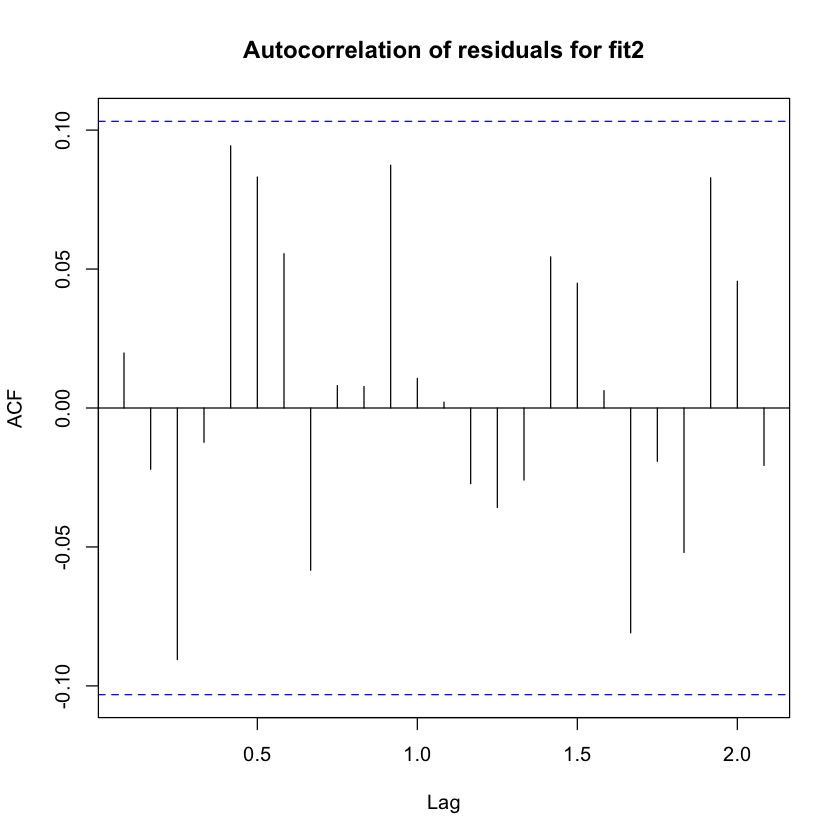

In [40]:
acf(res2,main = "Autocorrelation of residuals for fit2")

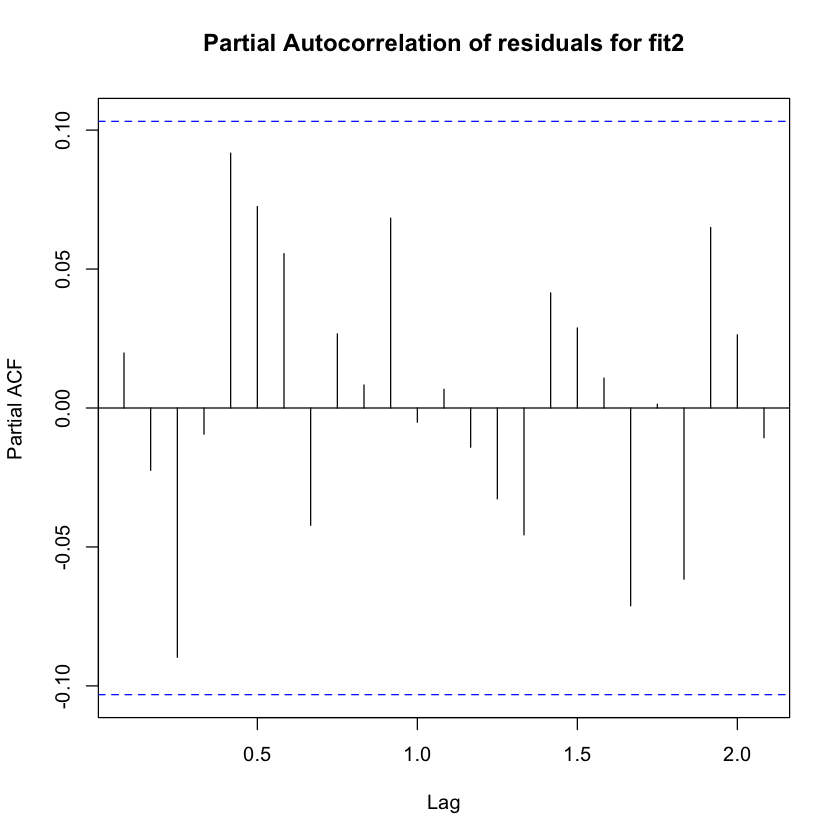

In [41]:
pacf(res2,main = "Partial Autocorrelation of residuals for fit2")

Looking at the mean and variance we see that mean is close to zero and the variance is small this favorable as already mentioned because we are trying to approximate a white noise proccess. Further we see that in the case of the PACF and ACF for this model all of our lags fall within the confidence interval and can therefore be considered as zero. This is desirable in our models again because we would like to approxoimate white noise. We proceed to run tests on the fitted model.

### Box-Pierce and Ljung-Box test

In [42]:
Box.test(res2, lag = 12, type = c("Box-Pierce"), fitdf = 4)
Box.test(res2, lag = 12, type = c("Ljung-Box"), fitdf = 4)
Box.test(res2^2, lag = 12, type = c("Ljung-Box"), fitdf = 0)


	Box-Pierce test

data:  res2
X-squared = 14.222, df = 8, p-value = 0.07616



	Box-Ljung test

data:  res2
X-squared = 14.555, df = 8, p-value = 0.06839



	Box-Ljung test

data:  res2^2
X-squared = 16.73, df = 12, p-value = 0.1601


The Box-Pierce test examines whether the residuals of the time series follow a white noise distribution. The Ljung-Box examines whether any group of autocorellations of a time series are nonzero. We see that for all test we have pvalues greater than 0.05. Our first fitted model passes all three of these tests. Further we proceed to run a McLeod.Li.test and shapiro test.

### Mcleod-Li Test and Shapiro Test


	Shapiro-Wilk normality test

data:  res2
W = 0.98773, p-value = 0.003842


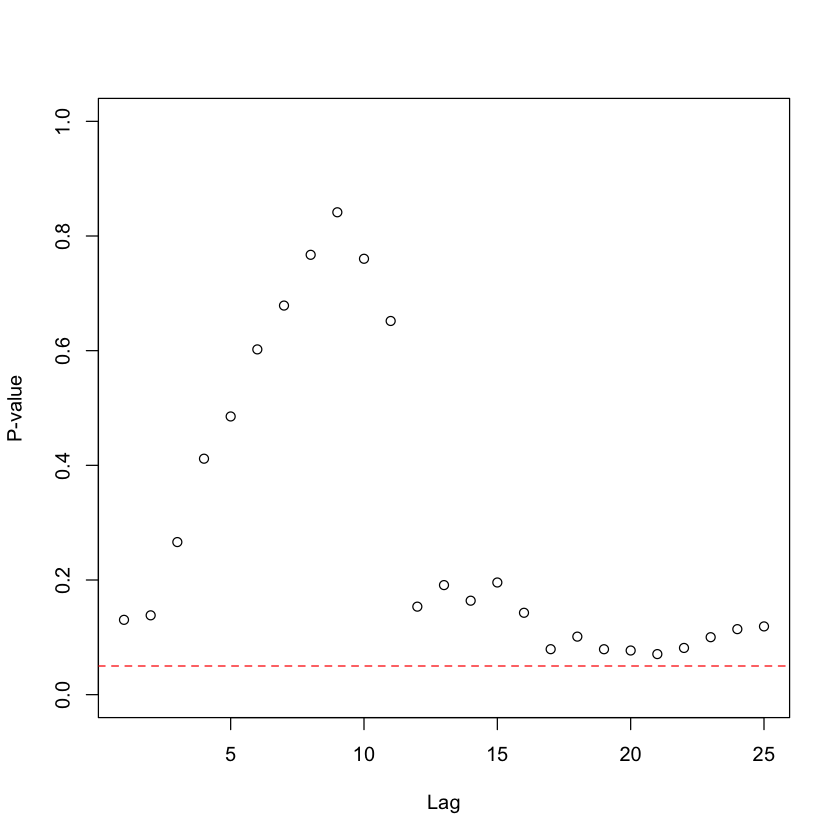

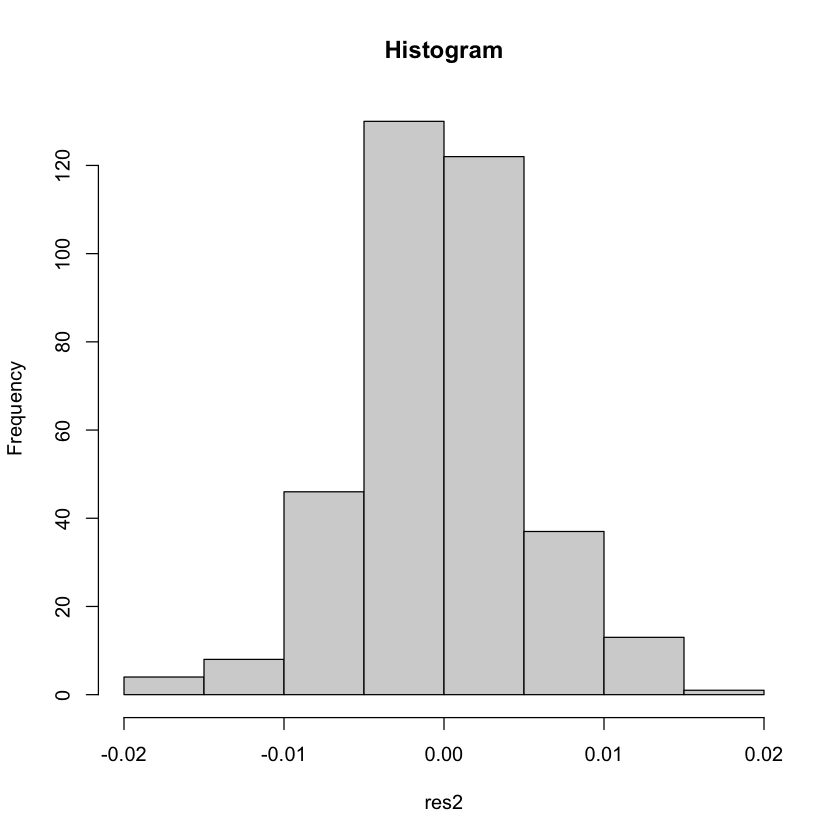

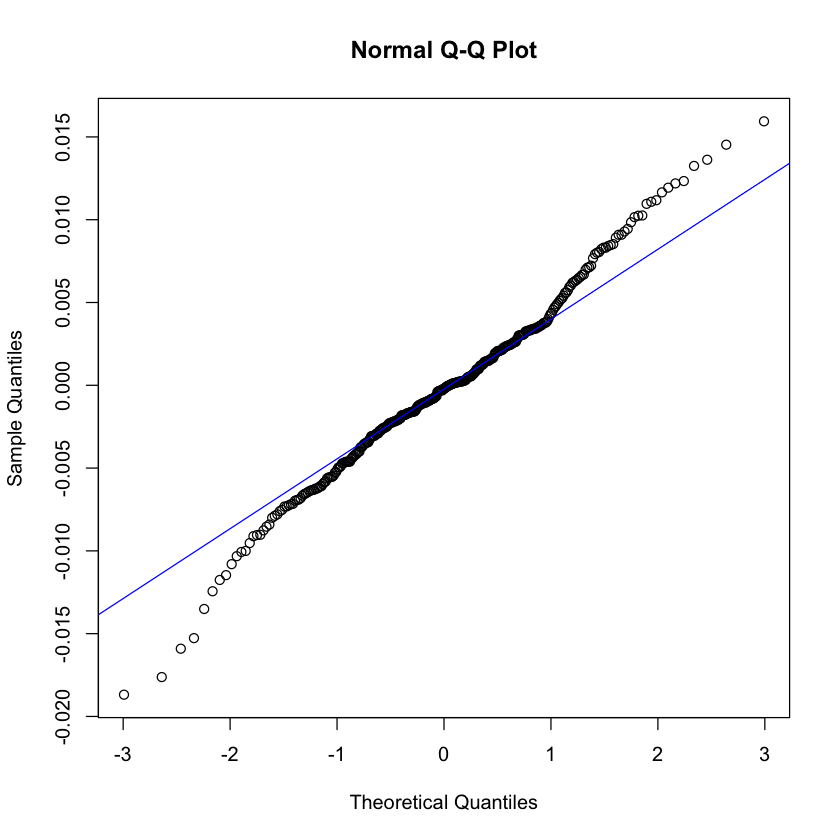

In [53]:
McLeod.Li.test(fit2)
shapiro.test(res2)
# Histogram
hist(res2,main = "Histogram")
# q-q plot
qqnorm(res2)
qqline(res2,col ="blue")

The shapiro test is a test of normality for the residuals. We see that our fitted model passses this test and can further conclude that the residuals are normally distributed by the histogram and by the majority of values following on the line for the Q-Q plot. The null hypothesis of the McLeod and Li test is that there is no autoregressive conditional heteroskedasticity (ARCH) among the lags considered. In the case of the McLeod.Li.test we see that no points fall under the red line, the condition that less than 5% of our points fall below the red line is satisfied. This indicates that we pass the test and accept the null there is no autoregressive conditional heteroskedasticity. Since the first model failed the MCLeod.Li.test and the shapiro test while the second pass all tests including the MCLeod.Li.test and shapiro test we proceed to choose our second fit as the best candidate for forecasting our data. We then proceed to forecast with this model. That is the best model is sarima(3,1,3)(1,1,1)[12].
In algebraic form we express this as:

$(1+0.3468B+0.7866B^{2}-0.2859B^{3})(1-0.0589B^{12})(1-B)(1-B^{12})=(1-0.0517B+0.5754B^{2}-0.6780B^{3})(1-0.8743B^{12})Z_{t}$

## Forecasting Using Extracted Time Series Model

Upper,Lower,Observations
<ts>,<ts>,<dbl>
237.4200,257.5347,251
254.5208,280.3438,285
239.7693,266.1861,260
248.6540,278.2968,272
245.3845,276.1142,265
263.8452,299.4048,296
268.0823,306.2600,312
265.2348,304.4439,289
258.8970,298.4851,282


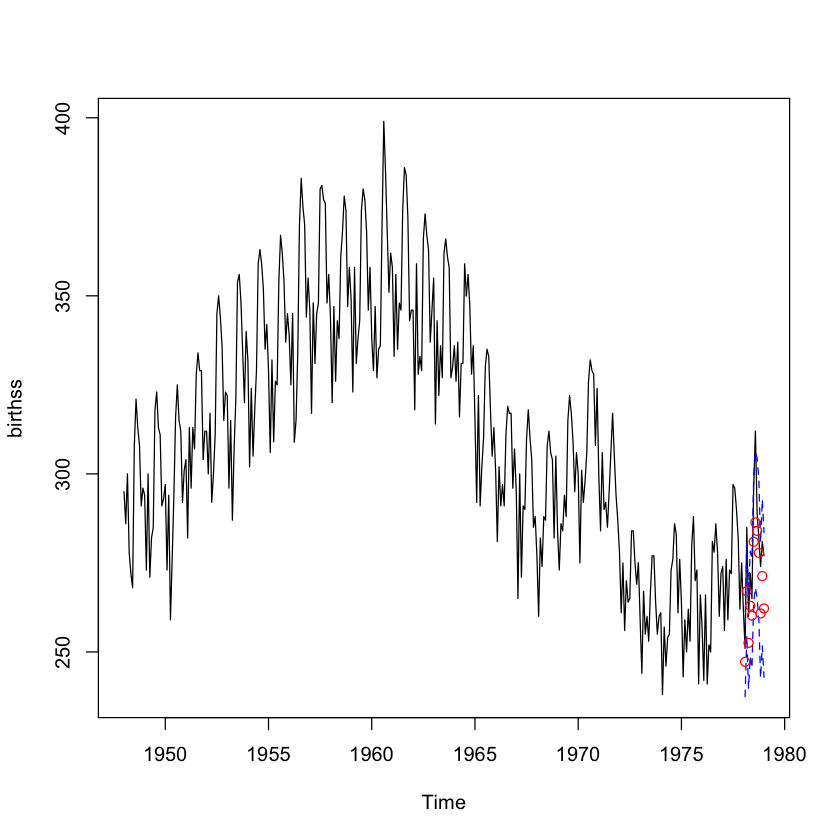

In [48]:
pred.tr <- predict(fit2, n.ahead = 12)
U.tr= pred.tr$pred + 2*pred.tr$se 
L.tr= pred.tr$pred - 2*pred.tr$se 
pred.orig <- ((lambda*(pred.tr$pred))+1)^(1/lambda)
U= ((lambda*U.tr)+1)^(1/lambda)
L= ((lambda*L.tr)+1)^(1/lambda)
ts.plot(birthss)
lines(U, col="blue", lty="dashed")
lines(L, col="blue", lty="dashed")
points( pred.orig, col="red")
comp3<-data.frame(Lower=L,Upper=U,OBS=actual)
names(comp3)<-c("Upper","Lower","Observations")
comp3

In this all of our 12 observed values fall within the confidence interval with the exception of the 7th and 2nd value. These values pertain to those observed in the months of 3/1978 and 9/1978. Since the majority of the values fall within the confidence interval we can assign these values falling out of the confidence interval as something that the sarima model did not capture due to either some externality or the characteristics of general sarima models. We still hold that the best model is sarima(3,1,3)(1,1,1)[12].

## Conclusions

The original intention of our model was to analyze the U.S Monthly Births with the intention of fitting the best time series model we could find and then after forecast with it or at the least show it to be capable of forecasting. In general when attmepting to fit and forecast data by fitting into a time series model it is necessary to transform data into normal, detrended, and deseasonalized data. In this attempt we were successful, we were able to deseasonalize our data, finding the seasonality to be yearly or at lag 12 since our data is sampled monthly . We were able to transform our data into further normalized data using a box-cox transformation and thenafter a detrended data by differencing at lag 1. After doing this we were able to take the stationary distribution and use Aicc criterion and diagnostic testing to find the best model that fitted our data. The concluded best model was sarima(3,1,3)(1,1,1)[12] since we only differenced at lag 1 once and lag 12 once and determined P=1 and Q=1 from the ACF and PACF and found the model at p=3 and q=3 to be the lowest Aicc that passed all diagnostic tests. After fitting our model we were able to forecast our model but found that 2 values out of 12 observations were outside the confidence intervals, although we chose this model to be the best one in this instance we also conclude that there was something that the model was not able to capture.